COLUMN_NAME EXPLANATION SAMPLE

drops 
PRIM_TKT_NUM: Müşteri bilet numarasıdır 2,307,664,176
CITY_NM: Varış istasyonunun şehir adıdır ISTANBUL
CNTRY_NM: Varış istasyonunun ülke adıdır TURKEY
ORG_CITY_NM: Kalkış istasyonunun şehir adıdır ADIYAMAN
ORG_CNTRY_NM: Kalkış istasyonunun ülke adıdır TURKEY

gropby:
CUST_KEY: Müşteriye özel bir numaradır 2670242

SEG_LCL_DEP_DT: GMT saat türünden kalkış günü bilgisidir 4/16/2017 0:00

ORGN_AP: Kalkış istasyonunun airport kodudur ADF
DSTN_AP: Varış istasyonunun airport kodudur IST

DOM_INTNL_FLAG: Seyahatin yurtiçi, yurtdışı olduğunu gösterir (D:Domestic, I: International)
JRNY_TYP: Seyahatin tek yön mü, gidiş- dönüş mü olduğunu gösterir (O:One-Way, R: Return)
TOP1_ORG_MKT_REGN: Müşterinin en çok çıkış yaptığı şehrin Pazarlama birimince  tanımlanan Region bilgisini içerir - Domestic
TOP1_ORG_CTY: Müşterinin en çok çıkış yaptığı şehirdir SIVAS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from collections import Counter

In [2]:
def find_transitions(df):
    
    flight_pairs = list(zip(df['ORG_CITY_NM'], df['CITY_NM']))
    pair_counts = Counter(flight_pairs)
    # all_cities = set(list(df['ORG_CITY_NM'].unique()) + list(df['CITY_NM'].unique()))
    shape = (len(all_cities_list), len(all_cities_list))
    
    transition_df = pd.DataFrame(np.zeros(shape),index=sorted(all_cities_list), columns=sorted(all_cities_list))
    
    for k, v in pair_counts.items():
        transition_df.loc[k[0], k[1]] = v
    
    return transition_df.div(transition_df.sum(axis=1)+0.0000001, axis=0)

In [3]:
def find_customer_transitions(cust_df):
    return find_transitions(cust_df)

In [4]:
def find_seasonal_transitions(df, season):
    seasonal_df = df[df['season']==season]
    return find_transitions(seasonal_df)

In [5]:
data_path = r'BirSonrakiDestinasyonTahminlemeBase.csv'

seperator = '|'
col_list = ['CUST_KEY', 'SEG_LCL_DEP_DT', 'ORG_CITY_NM', 'CITY_NM', 'DOM_INTNL_FLAG', 'JRNY_TYP',
       'TOP1_ORG_MKT_REGN', 'TOP1_ORG_CTY']

dtypes = {'CUST_KEY': 'int32',
          'ORG_CITY_NM': 'category',
          'CITY_NM': 'category',
          'DOM_INTNL_FLAG': 'category',
          'JRNY_TYP': 'category',
          'TOP1_ORG_MKT_REGN': 'category',
          'TOP1_ORG_CTY': 'category'}
dates = ['SEG_LCL_DEP_DT']

## alternative cities

In [6]:
alt_cities_path = r'AlternatifSehirler_BirSonrakiDestinasyonTahminleme.xlsx'

replace_for_alter_cities = {'ordu_giresun':'ordu-giresun',
                            'dar_es_salaam':'dar es salaam',
                            'dalaman_mugla':'dalaman (mugla)',
                            'tel_aviv':'tel aviv',
                            'sharm_el_sheikh':'sharm el-sheikh',
                            'abu_dhabi':'abu dhabi',
                           'basel_mulhouse':'basel/mulhouse',
                           'amasya___merzifon':'amasya/merzifon',
                           'balikesir_edremit':'balikesir edremit'}

alter_cities = pd.read_excel(alt_cities_path, usecols=['City_1', 'City_2'])

for col in alter_cities.columns:
    alter_cities[col] = alter_cities[col].str.lower()
alter_cities.replace(replace_for_alter_cities, inplace=True)

In [7]:
df = pd.read_csv(data_path, usecols=col_list, sep=seperator, parse_dates=dates, encoding='cp437')

In [8]:
df.memory_usage().sum()/(1024*1024*1024)

6.873442530632019

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115317228 entries, 0 to 115317227
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   CUST_KEY           int64         
 1   SEG_LCL_DEP_DT     datetime64[ns]
 2   CITY_NM            object        
 3   ORG_CITY_NM        object        
 4   DOM_INTNL_FLAG     object        
 5   JRNY_TYP           object        
 6   TOP1_ORG_MKT_REGN  object        
 7   TOP1_ORG_CTY       object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 6.9+ GB


In [10]:
df.head(3)

,CUST_KEY,SEG_LCL_DEP_DT,CITY_NM,ORG_CITY_NM,DOM_INTNL_FLAG,JRNY_TYP,TOP1_ORG_MKT_REGN,TOP1_ORG_CTY
0,2670242,2017-06-24,ISTANBUL,SIVAS,D,O,Domestic,SIVAS
1,170285826,2019-05-21,TEL AVIV,MIAMI,I,R,America,MIAMI
2,171132805,2019-06-25,KUTAHYA,FRANKFURT,I,R,Central Europe,FRANKFURT


In [11]:
replace_for_errors= {'ADDS ABABA' : 'ADDIS ABABA',
                    'MOGADSHU' : 'MOGADISHU',
                    'SNOP' : 'SINOP',
                    'ABDJAN':'ABIDJAN',
                    'THESSALONK' : 'THESSALONIKI',
                    'SULEYMANAH' : 'SULEYMANIAH',
                    'HO CH MNH CTY (SAGON)' : 'HO CHI MINH CITY (SAIGON)',
                    'SHRAZ' : 'SHIRAZ',
                    'SHARM EL-SHEKH' : 'SHARM EL-SHEIKH',
                    'VALENCA' : 'VALENCIA',
                    'TURN(TORNO)' : 'TURIN(TORINO)',
                    'TEKRDAG' : 'TEKIRDAG',
                    'LEFKOA' : 'LEFKOSA',
                    'KLMANJARO' : 'KILIMANJARO',
                    'SRT' : 'SIIRT'}

df.replace(replace_for_errors, inplace=True)

In [12]:
for col in ['ORG_CITY_NM', 'CITY_NM', 'TOP1_ORG_MKT_REGN', 'TOP1_ORG_CTY']:
    df[col] = df[col].str.lower()

In [ ]:
replace_for_errors2= {'╓stersund' : 'ostersund',
                    '─ngelholm' : 'angelholm',
                    'mal╔' : 'mali',
                    'taf':'taif',
                    'sevlle' : 'seville',
                    'asunci≤n' : 'asuncion',
                    'novosbrsk' : 'novosibirsk',
                    'oknawa' : 'okinawa',
                    'llongwe' : 'lilongwe',
                    'msurata' : 'misurata',
                    'vit≤ria' : 'vitoria',
                    'reykjavφk' : 'reykjavik',
                    'sπo luφs' : 'sao luis',
                    'ovedo' : 'oviedo',
                    'joπo pessoa' : 'joao pessoa',
                    'chapec≤':'chapeco',
                     'sπo josθ do rio preto':'sao jose do rio preto',
                     'san josθ del cabo':'san jose del cabo',
                     'san pedro sula	':'san pedro sula',
                     'mo i rana':'mo i rana',
                     'splt':'split',
                     'mazar-e sharf':'mazar-e sharif',
                     'san andrθs':'san andros',
                     'tapa':'taipa',
                     'hagσt±a, guam':'hagatna, guam',
                     'link÷ping':'linkoping',
                     'c·cuta':'cucuta',
                     'ilhθus':'ilheus'         
                    }
df.replace(replace_for_errors2, inplace=True)

In [13]:
# dropping flights that have same arrival and departure city
df = df[df['ORG_CITY_NM']!=df['CITY_NM']]

In [14]:
# # of customers that has more than 1 flight
sum(df['CUST_KEY'].duplicated(False))

94242881

In [15]:
df.shape

(114790271, 8)

## eda

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114790271 entries, 0 to 115317227
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   CUST_KEY           int64         
 1   SEG_LCL_DEP_DT     datetime64[ns]
 2   CITY_NM            object        
 3   ORG_CITY_NM        object        
 4   DOM_INTNL_FLAG     object        
 5   JRNY_TYP           object        
 6   TOP1_ORG_MKT_REGN  object        
 7   TOP1_ORG_CTY       object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 7.7+ GB


In [17]:
df.isna().sum()

CUST_KEY                  0
SEG_LCL_DEP_DT            0
CITY_NM               51284
ORG_CITY_NM           39349
DOM_INTNL_FLAG         4791
JRNY_TYP              22935
TOP1_ORG_MKT_REGN    184214
TOP1_ORG_CTY         184129
dtype: int64

In [18]:
len(df['CUST_KEY'].unique())

36576424

In [168]:
%%script False
import missingno as msgn
#read in data here
msgn.matrix(df,color=(0.45, 0.75, 0.25))

<AxesSubplot:>

MemoryError: Unable to allocate 25.3 GiB for an array with shape (94165087, 9, 4) and data type float64

<Figure size 1800x720 with 2 Axes>

In [20]:
df.dropna(subset=['CITY_NM', 'ORG_CITY_NM', 'TOP1_ORG_CTY'],inplace=True)

In [21]:
seasons = {'winter':[12,1,2], 
           'spring':[3,4,5], 
           'summer':[6,7,8],
           'fall':[9,10,11]}

season_mapping = {month:k for k,v in seasons.items() for month in v}
season_mapping

{12: 'winter',
 1: 'winter',
 2: 'winter',
 3: 'spring',
 4: 'spring',
 5: 'spring',
 6: 'summer',
 7: 'summer',
 8: 'summer',
 9: 'fall',
 10: 'fall',
 11: 'fall'}

In [23]:
df['season'] = df['SEG_LCL_DEP_DT'].apply(lambda x: season_mapping[x.month])

In [24]:
df.isna().sum()

CUST_KEY                0
SEG_LCL_DEP_DT          0
CITY_NM                 0
ORG_CITY_NM             0
DOM_INTNL_FLAG       2506
JRNY_TYP             4539
TOP1_ORG_MKT_REGN      83
TOP1_ORG_CTY            0
season                  0
dtype: int64

In [25]:
df.shape

(114541202, 9)

In [26]:
# converting columns to corresponding column types
for k, v in dtypes.items():
    df[k] = df[k].astype(v)

In [27]:
# finding flight pairs as dep-arr
flight_pairs = list(zip(df['ORG_CITY_NM'],df['CITY_NM']))
# counting flight pairs
pair_counts = Counter(flight_pairs)
# top 10 flight pairs
sorted(pair_counts.items(), key=lambda pair: pair[1], reverse=True)[0:10]

[(('istanbul', 'izmir'), 3321736),
 (('istanbul', 'ankara'), 3286059),
 (('ankara', 'istanbul'), 3065330),
 (('izmir', 'istanbul'), 2851972),
 (('istanbul', 'antalya'), 2434309),
 (('istanbul', 'adana'), 1944382),
 (('istanbul', 'trabzon'), 1877503),
 (('adana', 'istanbul'), 1743310),
 (('antalya', 'istanbul'), 1726738),
 (('trabzon', 'istanbul'), 1519597)]

In [28]:
# finding all unique cities
all_cities_list = set(list(df['ORG_CITY_NM'].unique()) + list(df['CITY_NM'].unique()))

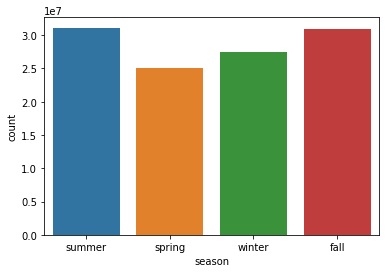

In [29]:
ax = sns.countplot(x="season", data=df)

## splitting data as train and test

In [30]:
%%script False
# grouping customers to find latest flights of each customer to split as test data
grouped_df = df.sort_values(by=['CUST_KEY', 'SEG_LCL_DEP_DT']).groupby(by='CUST_KEY')
test_indexes = grouped_df['SEG_LCL_DEP_DT'].idxmax()
with open("test_indexes.pickle","wb") as file:
    pickle.dump(test_indexes,file)

Couldn't find program: 'False'


In [31]:
with open("test_indexes.pickle",'rb') as file:
    test_indexes = pickle.load(file)

In [32]:
# customers who has 1 flights used as test

# flights of the customers who have only one flight
test_df1 = df.drop_duplicates(subset=['CUST_KEY'], keep=False)

df = df[df['CUST_KEY'].duplicated(False)]

# last flights of the customers who have more than one flight
test_df2 = df.loc[test_indexes]

train_df = df.drop(test_indexes)

In [33]:
%%script False
# use this for graph
count_by_days = df.groupby(by='SEG_LCL_DEP_DT').count()
ax = count_by_days.plot( y='CUST_KEY', figsize=(12,6))

Couldn't find program: 'False'


In [34]:
general_transitions = find_transitions(train_df)
seasonal_transitions_summer = find_seasonal_transitions(train_df, 'summer')
seasonal_transitions_winter = find_seasonal_transitions(train_df, 'winter')
seasonal_transitions_spring = find_seasonal_transitions(train_df, 'spring')
seasonal_transitions_fall = find_seasonal_transitions(train_df, 'fall')

seasonal_transitions = {'summer':seasonal_transitions_summer,
                        'winter':seasonal_transitions_winter,
                        'spring':seasonal_transitions_spring,
                        'fall':seasonal_transitions_fall}

In [35]:
def add_dataframes(general_df, seasonal_df, customer_df):
    
    tmp_df = pd.DataFrame(np.zeros(general_df.shape), 
                          columns=general_df.columns, index=general_df.index)
    seasonal_df = seasonal_df.add(tmp_df, fill_value=0.0)
    customer_df = customer_df.add(tmp_df, fill_value=0.0)
    
    return general_df + seasonal_df + customer_df

In [151]:
def predict(row, pred_dep='origin', season=None, n_pred=7, pred_type='only_cities', filter_alternate=True):
    """
    Parameters:
    -----------
    row: Series
        Data point to be predicted
        
    pred_dep: {'origin', 'top_city'}, default 'origin'
        Which city will be used for predicting the next flight. 
        'origin' refers to using test flight's origin city.
        'top_city' refers to using 'TOP1_ORG_CTY' of the customer.
        
    season: {None, 'winter', 'summer', 'spring', 'fall'}, default None
        Season param for using seasonal transition matrix. 
        None refers to using test flight's season
        
    n_pred: int, default 7
        Number of cities that model suggest to the customer.
        
    pred_type: {'only_cities', 'with_probs'}, default 'only_cities'
        'only_cities': returns only the top predicted cities
        'with_probs': returns predictions with probabilities
    
    filter_alternate: {True, False}, default True
        filters alternative cities from suggestions
    Returns:
    --------
    final_preds: dict or list
        if pred_type param is 'only_cities' it returns only predicted cities (list)
        if pred_type param is 'with_probs' it returns predicted cities with probabilities (dict)
        
    """
    
    cust_key = row['CUST_KEY']
    cust_df = train_df[train_df['CUST_KEY']==cust_key]

    # customer transitions
    cust_transitions = find_customer_transitions(cust_df)

    # seasonal customer transitions
    if season==None:
        season = row['season']
    if not season in seasons.keys():
        print('Wrong season')
        return False
    cust_seasonal_transitions = find_seasonal_transitions(cust_df, season)

    # weights
    w1 = 1
    w2 = len(cust_df)
    w3 = 2*w2
    total_sum = (w1+w2+w3)
    w1 = w1/total_sum
    w2 = w2/total_sum
    w3 = w3/total_sum
    

    if pred_dep == 'origin':
        departure = row['ORG_CITY_NM']
    elif pred_dep == 'top_city':
        departure = row['TOP1_ORG_CTY']
    else:
        print('Season param is wrong!')
        return False   
    
    # final_transitions = add_dataframes(w1*general_transitions, w2*seasonal_transitions[season], 
    #                                   w3*cust_seasonal_transitions)
    final_transitions = w1*general_transitions.values+w2*seasonal_transitions[season].values+w3*cust_seasonal_transitions.values
    final_transitions = pd.DataFrame(final_transitions, index=general_transitions.index, columns=general_transitions.index) 
    # final_transitions.loc[departure].sort_values(ascending=False)[0:n_pred]
    
    preds = final_transitions.loc[departure].sort_values(ascending=False)
    filtered_preds = []
    alternative_cities = []
    for city, prob in preds.items():
        
        if not city in alternative_cities:
            filtered_preds.append((city, prob))
            alternative_cities.extend(alter_cities.loc[alter_cities['City_1']==city, 'City_2'].values)
            
        if len(filtered_preds)>=n_pred:
            break
            
    final_preds = dict(filtered_preds)
    
    if pred_type == 'only_cities':
        return list(final_preds.keys())
    elif pred_type == 'with_probs':
        return final_preds
    else:
        print('Wrong return type!')
        return False

In [162]:
def calculate_accuracy(y_test, y_pred):
    trues = 0
    for true, pred in zip(y_test, y_pred):
        if true in pred:
            trues += 1
    return trues/len(y_test)

In [163]:
test_sample = test_df2.sample(10000)
test_sample.shape

(10000, 9)

In [164]:
%%time
results_2 = test_sample.apply(predict, axis=1, pred_type='only_cities')

Wall time: 16min 9s


In [160]:
calculate_accuracy

['istanbul', 'ankara', 'adana', 'antalya', 'izmir', 'gaziantep', 'samsun']

In [165]:
calculate_accuracy(test_sample['CITY_NM'], results_2)

0.6895

In [167]:
# n_pred = 5
test_sample = test_df2.sample(10000)
results_2 = test_sample.apply(predict, axis=1, pred_type='only_cities', n_pred=5)
calculate_accuracy(test_sample['CITY_NM'], results_2)

0.6384